In [1]:
!pip install binance_historical_data mplfinance stable-baselines3 backtesting tensorboard binance ta scikit-learn
# !pip install line_profiler


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
#!git clone https://github.com/Klok-e/python-price-predict-experiment.git

import sys

sys.path.insert(0, 'python-price-predict-experiment')

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# 
# import time
# import os
# try:
#   os.makedirs("./drive/MyDrive/colab/computed-data/")
# except:
#   pass

In [2]:
from util import download_and_process_data_if_available

df_tickers = download_and_process_data_if_available("cache/df_tickers.pkl")

Loading data from cache


In [ ]:
%load_ext tensorboard
%tensorboard --logdir data/tensorboard
# %load_ext tensorboard
# %tensorboard --logdir /content/drive/MyDrive/colab/computed-data/tensorboard

In [ ]:
from train_model import train_model
from env import CustomEnv

from stable_baselines3.common.env_checker import check_env

env = CustomEnv(df_tickers)
check_env(env)
del env

hidden_size_list = [128, 256, 512]
lstm_layers_list = [1, 2]
arch_list = [[256, 256, 256]]
window_size_list = [32, 64, 128]
for hidden_size in hidden_size_list:
    for lstm_layers in lstm_layers_list:
        for arch in arch_list:
            for window_size in window_size_list:
                print(f"hidden_size {hidden_size}, lstm_layers {lstm_layers}, window_size {window_size}")
                # dir = "/content/drive/MyDrive/colab/computed-data"
                dir = "data"
                train_model(df_tickers, hidden_size, lstm_layers, arch, 2_500_000, window_size, 5, dir)

In [ ]:
# !zip -r /content/drive/MyDrive/colab/model/tensorboard.zip /content/tensorboard/
# !zip -r /content/drive/MyDrive/colab/model/rl-model.zip /content/rl-model/

In [1]:
import pandas as pd
import numpy as np
import os

dirnames = next(os.walk(f"./rl-drom-google-drive/rl-model/"), (None, [], None))[1]  # [] if no file
for i, dir in enumerate(sorted(dirnames)):
    eval_path = f"./rl-drom-google-drive/rl-model/{dir}/best-model/results/evaluations.npz"
    print(eval_path)
    
    evaluations = np.load(eval_path)
    evaluations_df = pd.DataFrame()
    evaluations_df["timesteps"] = evaluations["timesteps"]
    evaluations_df["results"] = evaluations["results"].mean(axis=1)
    print(evaluations_df)

# evaluations = np.load("rl-model-best-model/results/evaluations.npz")
# evaluations_df = pd.DataFrame()
# evaluations_df["timesteps"] = evaluations["timesteps"]
# evaluations_df["results"] = evaluations["results"].mean(axis=1)
# evaluations_df

./rl-drom-google-drive/rl-model/hs128_lstm1_net[256, 256, 256]_ws128/best-model/results/evaluations.npz
    timesteps   results
0       99990  0.000000
1      199980  0.000000
2      299970  0.000000
3      399960  0.000000
4      499950  0.000000
5      599940  0.000000
6      699930  0.000000
7      799920  0.000000
8      899910  0.000000
9      999900  0.000000
10    1099890  0.000000
11    1199880  0.000000
12    1299870  0.000000
13    1399860  0.000000
14    1499850  0.000000
15    1599840  0.000000
16    1699830 -0.000002
17    1799820  0.000000
18    1899810  0.000000
19    1999800 -0.007457
20    2099790 -0.002729
21    2199780 -0.006686
22    2299770 -0.008661
23    2399760  0.008335
24    2499750  0.021195
./rl-drom-google-drive/rl-model/hs128_lstm1_net[256, 256, 256]_ws32/best-model/results/evaluations.npz
    timesteps   results
0       99990  0.000000
1      199980  0.000000
2      299970  0.000000
3      399960  0.000000
4      499950  0.000000
5      599940  0.000000
6

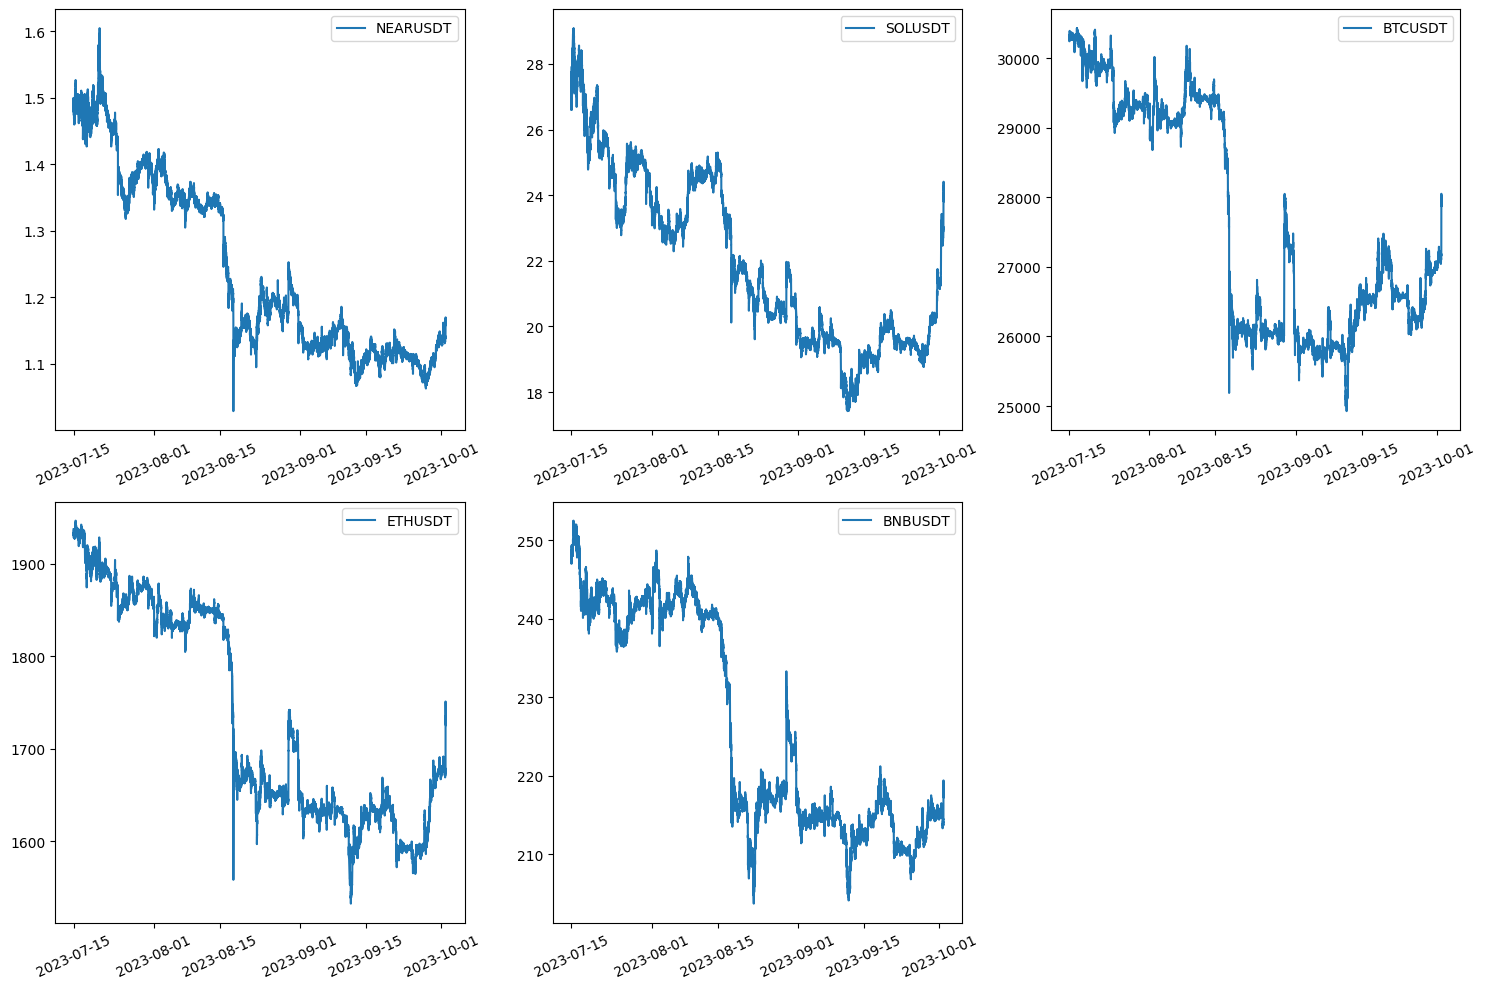

In [24]:
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

# Number of rows and columns for the subplot grid
nrows, ncols = 2, 3

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
axs = axs.flatten()  # Flatten the array to easily iterate over it

# Iterate over each DataFrame and its corresponding axis
for (df_scaled, df, scaler, name), ax in zip(df_tickers, axs[:5]):
    start = "2023-07-15"
    end = "2023-10-01"

    y = df.loc[start:end].Close

    ax.plot(y, label=name)

    # Set date formatting for x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    
    # Rotate date labels for clarity
    for label in ax.get_xticklabels():
        label.set_rotation(25)

    ax.legend()

if len(df_tickers) < 6:
    axs[5].axis('off')

# Adjust the layout
plt.tight_layout()
plt.savefig("prices of different coints from 2023-07-15 to 2023-10-01.png")